## Importing Libraries

In [1]:
import os
import cv2
import random
import shutil
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')

## Load Image Paths/Labels and Converting into DataFrame

In [2]:
DATASET_DIR = "Plastic types"

In [3]:
categories = os.listdir(DATASET_DIR)

images_paths = []
labels = []

for label in categories:
    folder = os.path.join(DATASET_DIR, label)
    for img_file in os.listdir(folder):
        if img_file.lower().endswith(('jpg', 'png', 'jpeg')):
            images_paths.append(os.path.join(folder, img_file))
            labels.append(label)

In [4]:
df = pd.DataFrame({
    'image': images_paths,
    'label': labels
})

df.head()

,image,label
0,Plastic types\Others\image_0.jpg,Others
1,Plastic types\Others\image_1.jpg,Others
2,Plastic types\Others\image_10.jpg,Others
3,Plastic types\Others\image_100.jpg,Others
4,Plastic types\Others\image_101.jpg,Others


### Check Class Balance

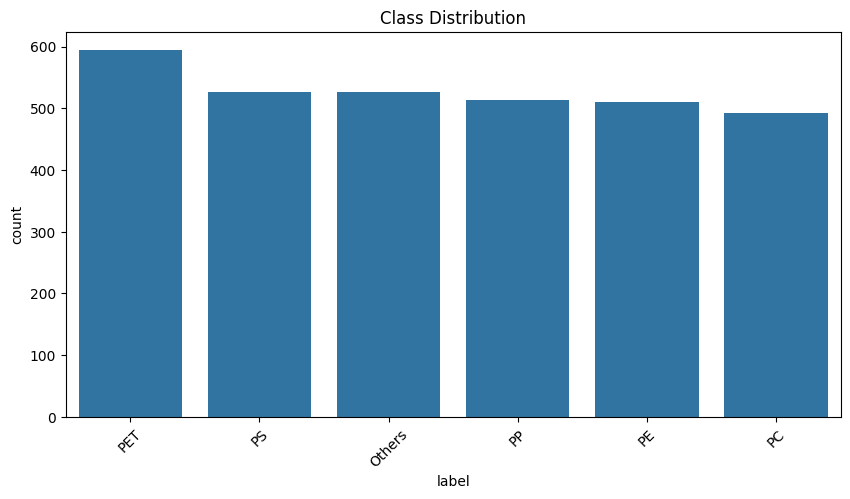

In [5]:
plt.figure(figsize=(10,5))
sns.countplot(data = df, x = 'label', order=df['label'].value_counts().index)
plt.title('Class Distribution')
plt.xticks(rotation = 45)
plt.show()

In [6]:
df['label'].value_counts()

label
PET       594
PS        527
Others    526
PP        514
PE        511
PC        492
Name: count, dtype: int64

### Clean Corrupted and Small Images

In [8]:
bad_files = []

for path in df['image']:
    img = cv2.imread(path)
    if img is None or img.shape[0] < 50 or img.shape[1] < 50:
        bad_files.append(path)

print(f"Found {len(bad_files)} bad image(s).")

Found 1013 bad image(s).


In [9]:
# Move bad images to a folder

bad_dir = 'bad_images'
os.makedirs(bad_dir, exist_ok=True)

for path in bad_files:
    try:
        shutil.move(path, os.path.join(bad_dir, os.path.basename(path)))
        print(f"Moved: {path}")
    except Exception as e:
        print(f"Failed to move {path}: {e}")

# Remove those paths from balanced_df
df = df[~df['image'].isin(bad_files)].reset_index(drop=True)


Moved: Plastic types\Others\image_0.jpg
Moved: Plastic types\Others\image_10.jpg
Moved: Plastic types\Others\image_102.jpg
Moved: Plastic types\Others\image_108.jpg
Moved: Plastic types\Others\image_11.jpg
Moved: Plastic types\Others\image_118.jpg
Moved: Plastic types\Others\image_121.jpg
Moved: Plastic types\Others\image_123.jpg
Moved: Plastic types\Others\image_124.jpg
Moved: Plastic types\Others\image_129.jpg
Moved: Plastic types\Others\image_132.jpg
Moved: Plastic types\Others\image_133.jpg
Moved: Plastic types\Others\image_134.jpg
Moved: Plastic types\Others\image_136.jpg
Moved: Plastic types\Others\image_142.jpg
Moved: Plastic types\Others\image_144.jpg
Moved: Plastic types\Others\image_148.jpg
Moved: Plastic types\Others\image_151.jpg
Moved: Plastic types\Others\image_157.jpg
Moved: Plastic types\Others\image_16.jpg
Moved: Plastic types\Others\image_160.jpg
Moved: Plastic types\Others\image_161.jpg
Moved: Plastic types\Others\image_162.jpg
Moved: Plastic types\Others\image_164.j

### Balancing the Data

In [10]:
min_count = df['label'].value_counts().min()
balanced_df = df.groupby('label').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_df['label'].value_counts()

label
PE        328
PP        328
Others    328
PET       328
PS        328
PC        328
Name: count, dtype: int64

### Visualizing 5 Images from Each Class

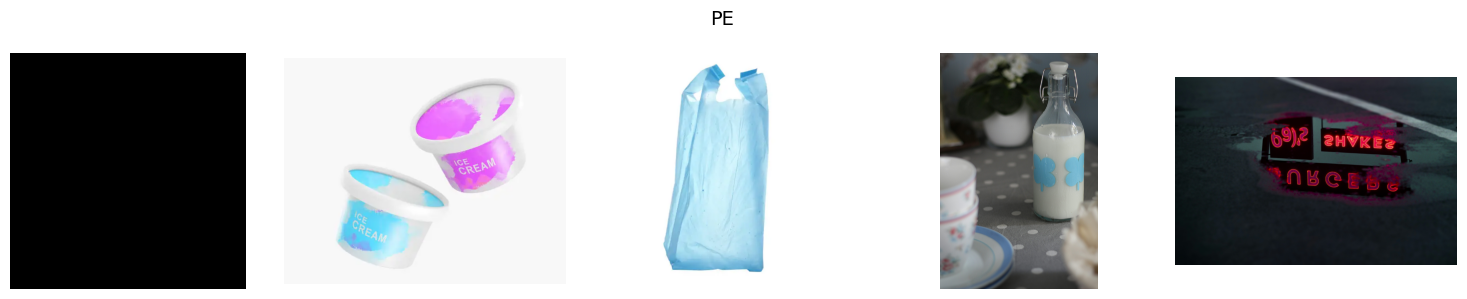

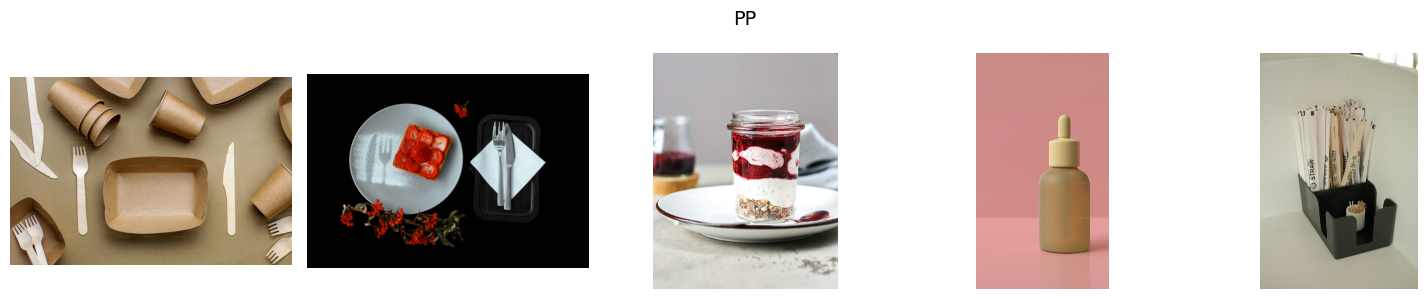

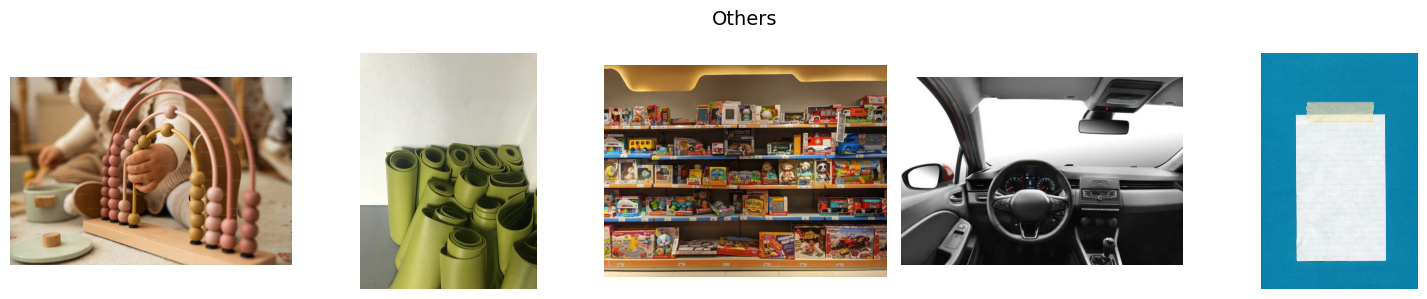

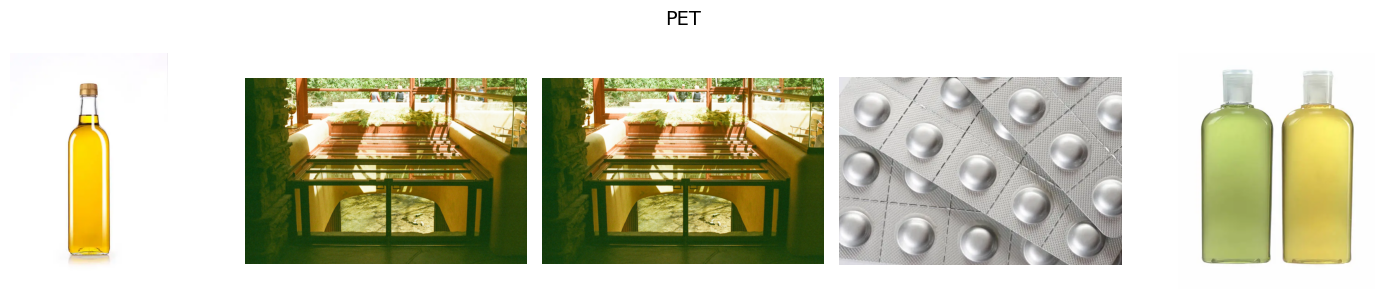

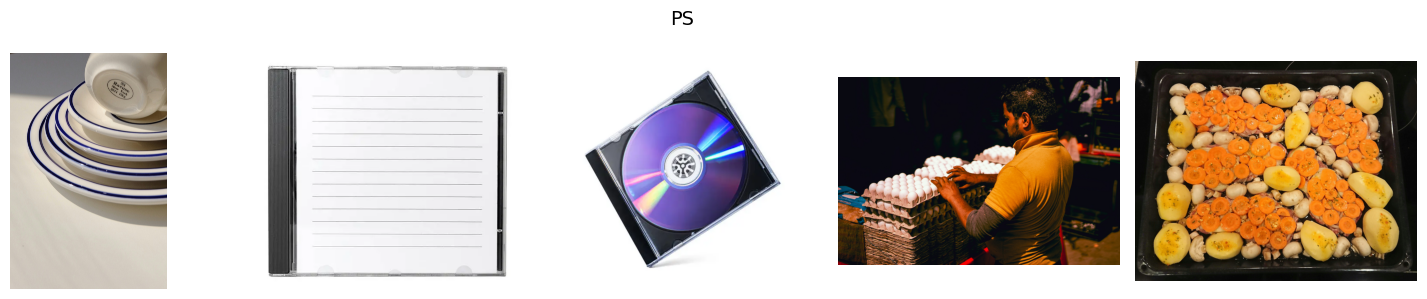

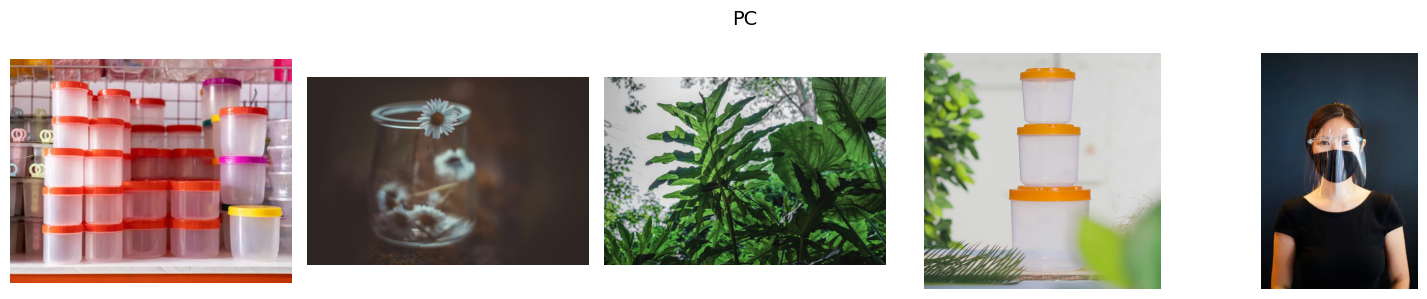

In [11]:
for category in balanced_df['label'].unique():
    sample_imgs = balanced_df[balanced_df['label'] == category].sample(5)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(category, fontsize=14)

    for i, img_path in enumerate(sample_imgs['image']):
        img = cv2.imread(img_path)

        if img is None or img.shape[0] < 50 or img.shape[1] < 50:  # very small or invalid
            print(f"Warning: Skipping corrupted or small image: {img_path}")
            axes[i].text(0.5, 0.5, 'Invalid image', ha='center', va='center', fontsize=10)
            axes[i].set_facecolor('lightgray')
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img)

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


### Data Augmentation

In [12]:
img_height, img_width = 128, 128

datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip =True,
    validation_split = 0.2
)

### Split Data

In [27]:
balanced_df = balanced_df.sample(frac = 1, random_state= 42)

train_gen = datagen.flow_from_dataframe(
    dataframe = balanced_df,
    x_col = 'image',
    y_col = 'label',
    target_size = (img_height, img_width),
    class_mode = 'categorical',
    batch_size = 32,
    subset = 'training'
)

val_gen = datagen.flow_from_dataframe(
    dataframe=balanced_df,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=32,
    subset='validation',
    shuffle = False
)

Found 1575 validated image filenames belonging to 6 classes.
Found 393 validated image filenames belonging to 6 classes.


# Model Training

In [14]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

#### Model 1: Simple CNN

In [15]:
model1 = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(categories), activation='softmax')
])

In [16]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
history1 = model1.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[early_stop])

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.1455 - loss: 2.3361 - val_accuracy: 0.1959 - val_loss: 1.7838
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.2235 - loss: 1.7471 - val_accuracy: 0.2265 - val_loss: 1.7838
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.2340 - loss: 1.7336 - val_accuracy: 0.2188 - val_loss: 1.7767
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.2697 - loss: 1.7287 - val_accuracy: 0.1985 - val_loss: 1.8551
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.2848 - loss: 1.7103 - val_accuracy: 0.2366 - val_loss: 1.8402
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.2908 - loss: 1.7010 - val_accuracy: 0.2290 - val_loss: 1.8036
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.3087 - loss: 1.6572 - val_accuracy: 0.2341 - val_loss: 1.8340
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.3121 - loss: 1.6513 - val_accuracy: 0.2723 - val_loss:

#### Classification Report and Accuracy

In [28]:
val_gen.reset()
preds = model1.predict(val_gen, verbose = 1)
y_pred = np.argmax(preds, axis = 1)
y_true = val_gen.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step


In [29]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys()))

Classification Report:

              precision    recall  f1-score   support

      Others       0.48      0.31      0.38        71
          PC       0.46      0.21      0.29        76
          PE       0.40      0.33      0.37        63
         PET       0.24      0.43      0.31        61
          PP       0.39      0.39      0.39        57
          PS       0.37      0.54      0.44        65

    accuracy                           0.36       393
   macro avg       0.39      0.37      0.36       393
weighted avg       0.39      0.36      0.36       393



In [30]:
val_accuracy = np.mean(y_pred == y_true)
print(f"\nValidation Accuracy: {val_accuracy:.2f}")


Validation Accuracy: 0.36


#### Model 2: Transfer Learning using MobileNetV2

In [21]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model2 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(categories), activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 14s 1us/step


In [22]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
history2 = model2.fit(train_gen, validation_data=val_gen, epochs=50)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.2664 - loss: 1.8855 - val_accuracy: 0.4198 - val_loss: 1.4950
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.5441 - loss: 1.2298 - val_accuracy: 0.4402 - val_loss: 1.4722
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.5889 - loss: 1.0902 - val_accuracy: 0.4555 - val_loss: 1.4254
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.6351 - loss: 0.9183 - val_accuracy: 0.4809 - val_loss: 1.3547
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.7195 - loss: 0.7863 - val_accuracy: 0.4733 - val_loss: 1.4253
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7860 - loss: 0.6586 - val_accuracy: 0.5420 - val_loss: 1.3882
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7850 - loss: 0.6476 - val_accuracy: 0.5115 - val_loss: 1.3936
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8059 - loss: 0.5622 - val_accuracy: 0.4784 - val_loss:

#### Classification Report and Accuracy

In [31]:
val_gen.reset()
preds_2 = model2.predict(val_gen, verbose = 1)
y_pred_2 = np.argmax(preds_2, axis = 1)
y_true_2 = val_gen.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step


In [32]:
print("Classification Report:\n")
print(classification_report(y_true_2, y_pred_2, target_names=val_gen.class_indices.keys()))

Classification Report:

              precision    recall  f1-score   support

      Others       0.89      0.90      0.90        71
          PC       0.88      0.84      0.86        76
          PE       0.90      0.89      0.90        63
         PET       0.90      0.87      0.88        61
          PP       0.85      0.89      0.87        57
          PS       0.88      0.91      0.89        65

    accuracy                           0.88       393
   macro avg       0.88      0.88      0.88       393
weighted avg       0.88      0.88      0.88       393



In [33]:
val_accuracy_2 = np.mean(y_pred_2 == y_true_2)
print(f"\nValidation Accuracy: {val_accuracy_2:.2f}")


Validation Accuracy: 0.88


### Saving the Model

In [34]:
model2.save("best_plastic_model.h5")